# Nuovi Decessi e Terapie Intensive

Correlazione tra nuovi deceduti e terapie intensive.

> Max Pierini

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import dates as mdates
import matplotlib.gridspec as gridspec
import statsmodels.api as sm

from IPython.display import Markdown

In [2]:
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    index_col='data', parse_dates=['data']
).sort_values('data')
df.index = df.index.normalize()

In [4]:
def covid_regioni():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
        parse_dates=['data'],
        index_col=['data'],
        squeeze=True).sort_index()
    df.index = df.index.normalize()
    return df

In [5]:
ti_it = df.ingressi_terapia_intensiva.dropna()

In [6]:
rg = covid_regioni()

ti_rg = rg[['denominazione_regione', 'ingressi_terapia_intensiva']].dropna()

In [7]:
ti_mod = sm.OLS.from_formula(
    'ingressi_terapia_intensiva ~ index',
    data=ti_it.reset_index().reset_index()
).fit()

In [8]:
ti_pred = ti_mod.get_prediction(ti_it.reset_index().reset_index())

In [9]:
pred_mu = ti_pred.predicted_mean
pred_ci = ti_pred.conf_int(alpha=.05)

In [10]:
ti_beta_mu = ti_mod.params['index']
ti_beta_ci = ti_mod.conf_int(alpha=.05).loc['index'].values

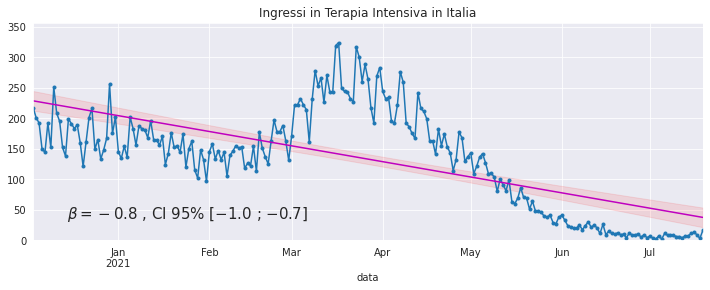

In [11]:
ax = ti_it.plot(
    ylim=(0,ti_it.values.max()*1.1), 
    marker='.',
    title='Ingressi in Terapia Intensiva in Italia',
    figsize=(12, 4)
)
ax.plot(ti_it.index, pred_mu, color='m')
ax.fill_between(
    ti_it.index,
    pred_ci[:,0], pred_ci[:,1],
    color='r', alpha=.1
)
ax.text(
    .05, .1,
    fr"$\beta = {ti_beta_mu:.1f}$ , CI 95% [${ti_beta_ci[0]:.1f}$ ; ${ti_beta_ci[1]:.1f}$]",
    transform=ax.transAxes,
    fontsize=15
)
plt.show()

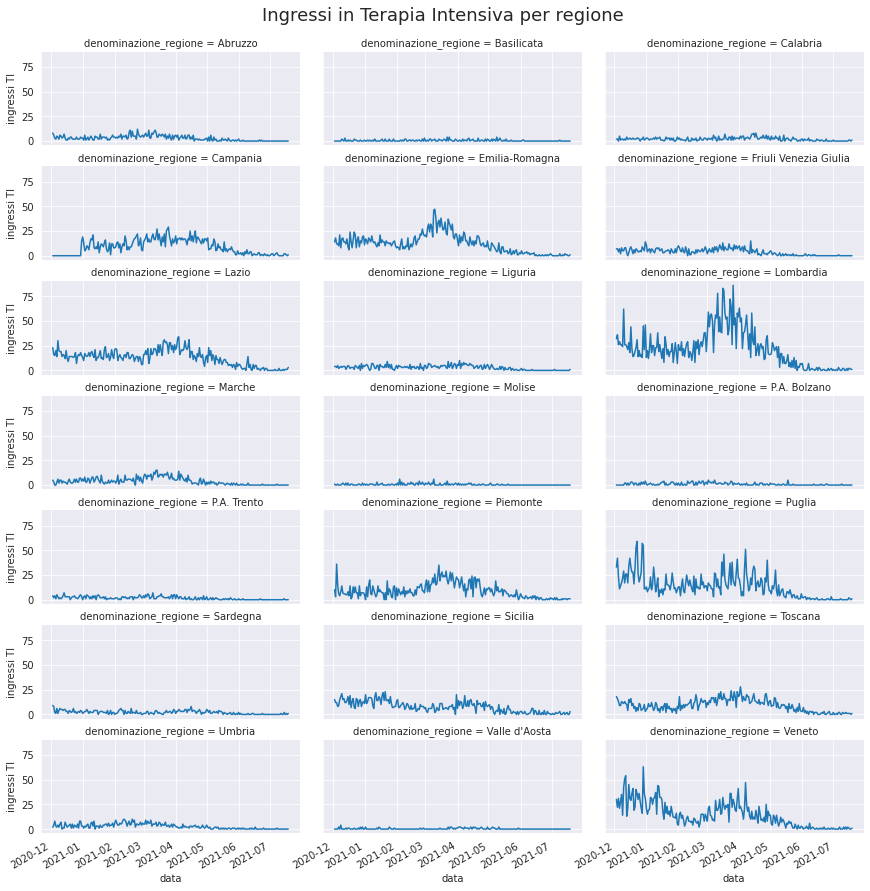

In [12]:
g = sns.relplot(
    kind='line',
    data=ti_rg,
    x='data', y='ingressi_terapia_intensiva',
    col='denominazione_regione', col_wrap=3,
    aspect=2, height=2,
)
g.fig.autofmt_xdate()
g.set_ylabels('ingressi TI')
g.fig.suptitle('Ingressi in Terapia Intensiva per regione', y=1.02, fontsize=18)
plt.show()

In [13]:
df['nuovi_deceduti'] = df.deceduti.diff()

In [14]:
df['dec_int_rate'] = df.nuovi_deceduti / df.terapia_intensiva

In [15]:
df['dec_int_rate_filtered'] = df.dec_int_rate

Rapporto grezzo nuovi deceduti su terapie intensive:

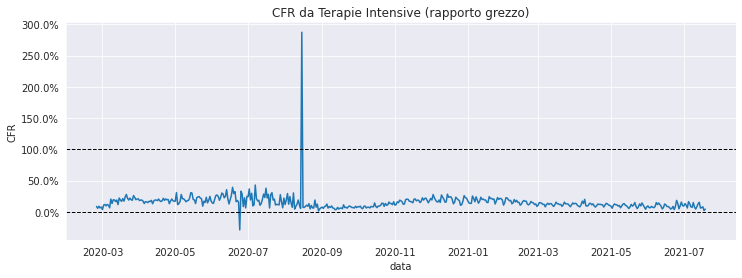

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(
    data=df,
    x='data', y='dec_int_rate',
    ax=ax
)
ax.axhline(0, ls='--', lw=1, color='k')
ax.axhline(1, ls='--', lw=1, color='k')
ax.set(
    ylabel='CFR',
    title='CFR da Terapie Intensive (rapporto grezzo)'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
plt.show()

Definizione e rimozione outliers (minori di 0% e maggiori di 100%)

In [17]:
outliers = ((df.dec_int_rate > 1) | (df.dec_int_rate < 0)).values.nonzero()
for outlier in outliers:
    for idx in outlier:
        print(f"{df.index[idx]}: {df.dec_int_rate[idx]:.2%}")
        df.at[df.index[idx], 'dec_int_rate_filtered'] = df.iloc[idx-1]['dec_int_rate_filtered']

2020-06-24 00:00:00: -28.97%
2020-08-15 00:00:00: 287.27%


Fit su polinomio di ottavo grado

In [18]:
grado = 10

In [19]:
ti_roll = df.dec_int_rate_filtered.rolling(
    window=7,
    #win_type='gaussian',
    center=True,
).mean(std=3).dropna()

In [20]:
params = np.polyfit(
    np.array(range(ti_roll.index.size)), ti_roll.values, grado
)
func = np.poly1d(params)
fitted = func(np.array(range(ti_roll.index.size)))

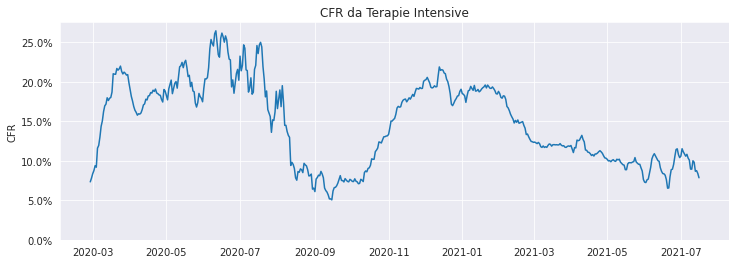

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))
#ax.plot(ti_roll.index, fitted, lw=3)
ax.plot(ti_roll)
ax.set(
    ylabel='CFR',
    title=f'CFR da Terapie Intensive'
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
ax.set(
    ylim=(0, ax.get_ylim()[1])
)
plt.show();

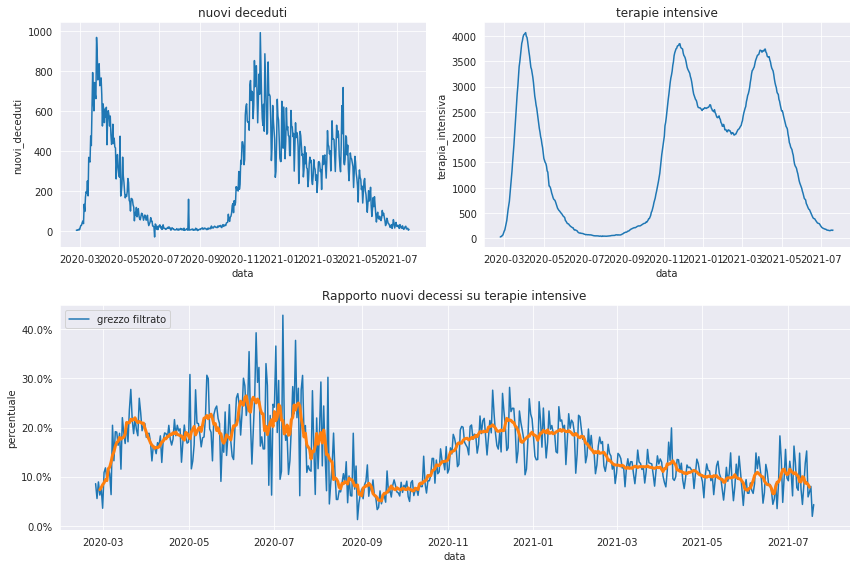

In [22]:
fig = plt.figure(tight_layout=True, figsize=(12, 8))
gs = gridspec.GridSpec(2, 2)

ax_sn = fig.add_subplot(gs[0, 0])
sns.lineplot(data=df, x='data', y='nuovi_deceduti', ax=ax_sn)
ax_sn.set_title('nuovi deceduti')

ax_dx = fig.add_subplot(gs[0, 1])
sns.lineplot(data=df, x='data', y='terapia_intensiva', ax=ax_dx)
ax_dx.set_title('terapie intensive')

ax = fig.add_subplot(gs[1, :])
sns.lineplot(
    data=df,
    x='data', y='dec_int_rate_filtered', 
    label='grezzo filtrato',
    ax=ax
)
#ax.plot(ti_roll.index, fitted, lw=4, label='fit su polinomio')
ax.plot(ti_roll, lw=3)
ax.legend(loc='upper left')
ax.set_ylabel('percentuale')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
ax.set_title('Rapporto nuovi decessi su terapie intensive')
plt.show()

Correlazione sulla linea temporale.

Per ovviare alla eteroschedasticità la correlazione sarà effettuata sul logaritmo

$$
\ln(\textrm{nuovi_deceduti}) = 
\alpha + \beta \cdot \ln(\textrm{terapia_intensiva})
$$

In [23]:
df['mese'] = [f"{m} {y}" for y, m in zip(df.index.year, df.index.month_name())]
df['mese_inv'] = [f"{y} {m}" for y, m in zip(df.index.year, df.index.month_name())]

In [24]:
df['mese_num'] = [int(f"{y}{m:02}") for y, m in zip(df.index.year, df.index.month)]

In [25]:
df.loc[df.nuovi_deceduti<=0, 'nuovi_deceduti'] = np.nan
df['nuovi_deceduti'] = df.nuovi_deceduti.fillna(method='bfill')

In [26]:
df['nuovi_deceduti_log'] = np.log(df.nuovi_deceduti)

In [27]:
df['terapia_intensiva_log'] = np.log(df.terapia_intensiva)

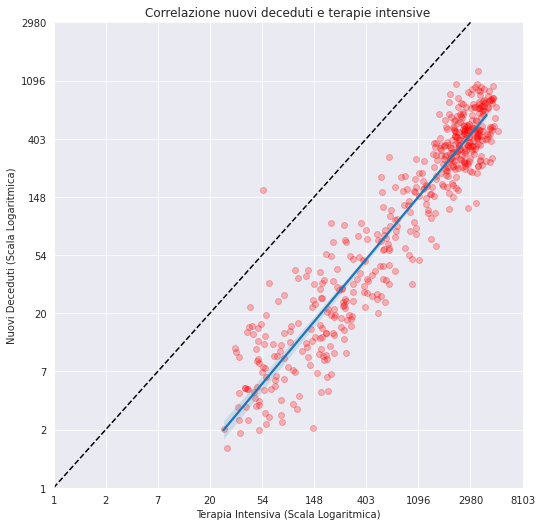

In [28]:
g = sns.lmplot(
    data=df,
    x='terapia_intensiva_log', y='nuovi_deceduti_log',
    x_jitter=.3, y_jitter=.3,
    order=1,
    height=7,
    scatter_kws={'alpha':.25, 'color':'r'}
)
g.set(
    xlim=(0, g.axes.flat[0].get_xlim()[1]),
    ylim=(0, g.axes.flat[0].get_ylim()[1]),
)
g.set(
    title='Correlazione nuovi deceduti e terapie intensive',
    xticks=g.axes.flat[0].get_xticks(),
    yticks=g.axes.flat[0].get_yticks(),
    xticklabels=np.exp(g.axes.flat[0].get_xticks()).astype(int),
    yticklabels=np.exp(g.axes.flat[0].get_yticks()).astype(int),
    ylabel="Nuovi Deceduti (Scala Logaritmica)",
    xlabel="Terapia Intensiva (Scala Logaritmica)",
)
g.axes.flat[0].axline(xy1=(1,1), slope=1, color='k', ls='--')
plt.show()

In [29]:
model = sm.OLS.from_formula('np.log(nuovi_deceduti) ~ np.log(terapia_intensiva)', data=df)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     np.log(nuovi_deceduti)   R-squared:                       0.908
Model:                                OLS   Adj. R-squared:                  0.908
Method:                     Least Squares   F-statistic:                     5036.
Date:                    Mon, 19 Jul 2021   Prob (F-statistic):          1.96e-266
Time:                            17:38:43   Log-Likelihood:                -373.33
No. Observations:                     512   AIC:                             750.7
Df Residuals:                         510   BIC:                             759.1
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.5030      0.103    -24.276      0.000      -2.706      -2.300
np.log(terapia_intensiva)     1.0722      0.015     70.962      0.000       1.042       1.102
==============================================================================
Omnibus:                       56.789   Durbin-Watson:                   0.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.913
Skew:                           0.286   Prob(JB):                     2.04e-65
Kurtosis:                       6.693   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
fit_res = {}
grouped = df.groupby('mese_num')
for mese in grouped:
    #print(mese[0])
    #print(mese[1][['nuovi_deceduti', 'terapia_intensiva']].head())
    try:
        fit_res.update({mese[0]: {}})
        _df = mese[1][['nuovi_deceduti', 'terapia_intensiva']]
        model = sm.OLS.from_formula('nuovi_deceduti ~ terapia_intensiva', data=_df.dropna())
        results = model.fit()
        fit_res[mese[0]]['R2'] = results.rsquared
        fit_res[mese[0]]['Intercept'] = results.params.Intercept
        fit_res[mese[0]]['coefficient'] = results.params.terapia_intensiva
    except Exception as err:
        print(err)

Correlazione lineare nuovi deceduti e terapie intensive per mese:

$$
\textrm{nuovi_deceduti}_{\textrm{mese}} = \alpha + \beta \cdot \textrm{terapia_intensiva}_{\textrm{mese}}
$$

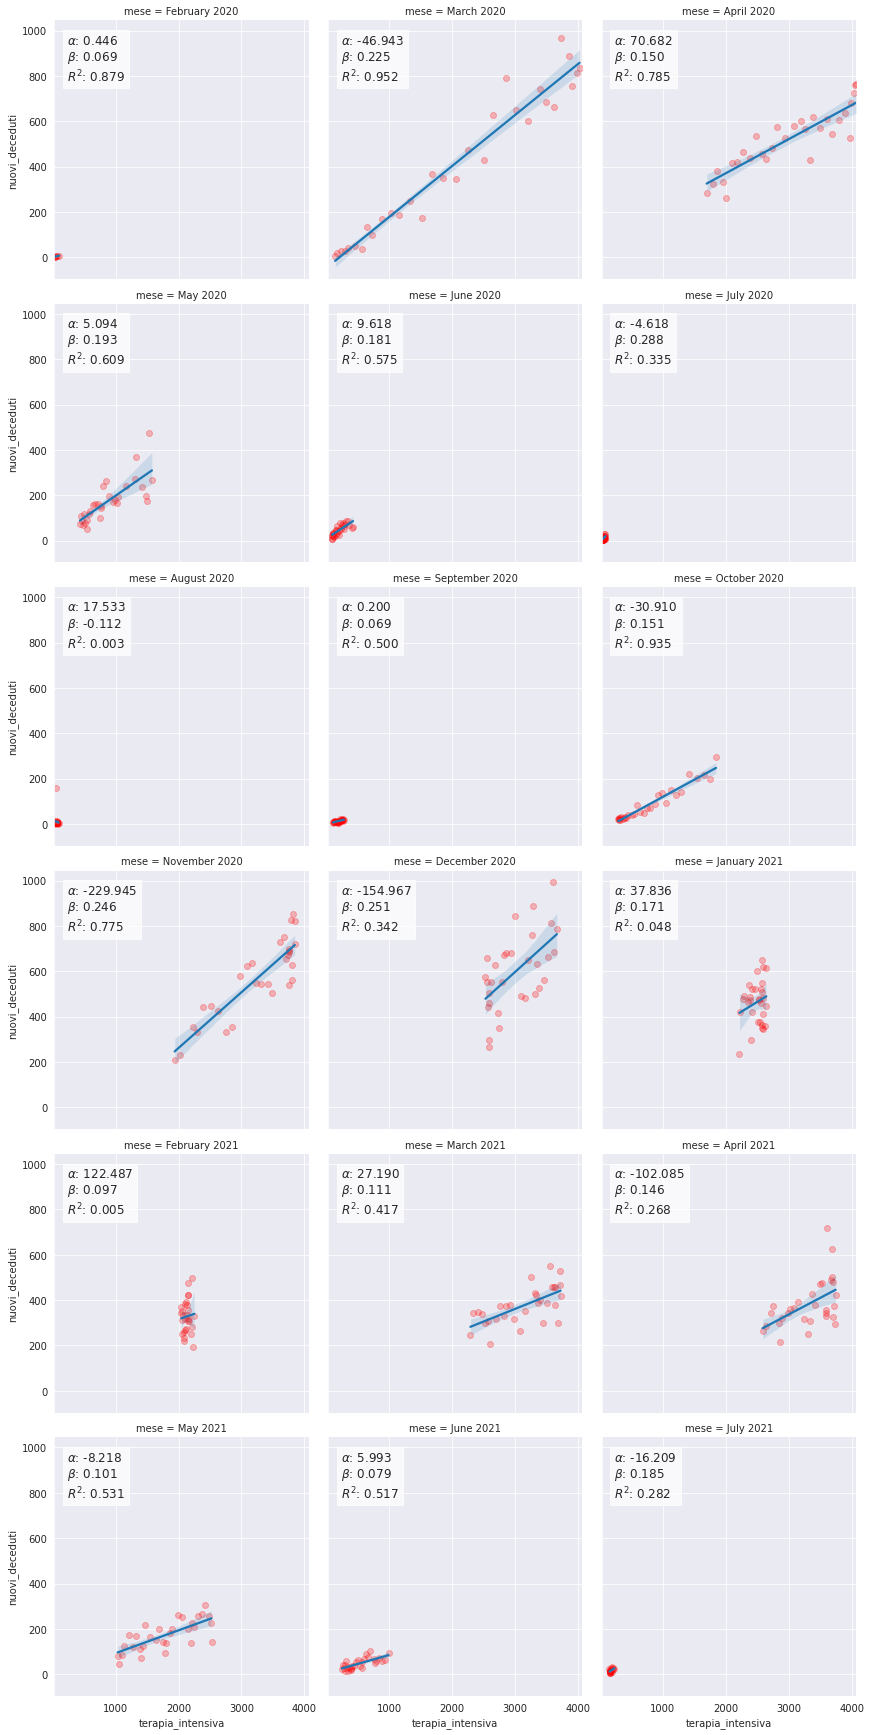

In [31]:
params = {}

g = sns.lmplot(
    data=df,
    x='terapia_intensiva', y='nuovi_deceduti',
    x_jitter=.3, y_jitter=.3,
    order=1,
    height=4, col='mese', col_wrap=3,
    #sharex=False, 
    #sharey=False,
    scatter_kws={'alpha':.25, 'color':'r'}
)
months = df.mese.unique()
months_inv = df.mese_inv.unique()
for i, res in enumerate(fit_res):
    xlim = g.axes.flat[i].get_xlim()
    ylim = g.axes.flat[i].get_ylim()
    
    res_txt = "not enough data"
    try:
        res_txt = fr"$\alpha$: {fit_res[res]['Intercept']:.3f}"+\
        "\n"+\
        fr"$\beta$: {fit_res[res]['coefficient']:.3f}"+\
        "\n"+\
        fr"$R^2$: {fit_res[res]['R2']:.3f}"
    except Exception as err:
        print(res, err)
    
    g.axes.flat[i].text(
        0.05, 0.85,
        res_txt,
        ha='left', va='center', fontsize=12,
        transform=g.axes.flat[i].transAxes,
        bbox=dict(facecolor='w', alpha=0.75)
    )
    try:
        params.update({months[i]: {
            'alpha': fit_res[res]['Intercept'], 
            'beta': fit_res[res]['coefficient'],
            'R2': fit_res[res]['R2'],
            'month_inv': months_inv[i],
        }})
    except Exception as err:
        print(res, err)

In [32]:
month_params = pd.DataFrame(params).T
month_params.drop('month_inv', axis=1)

,alpha,beta,R2
February 2020,0.446006,0.0693291,0.878506
March 2020,-46.9427,0.225071,0.951659
April 2020,70.6821,0.150324,0.785266
May 2020,5.09448,0.193365,0.608508
June 2020,9.61792,0.181337,0.574592
July 2020,-4.61802,0.288271,0.334849
August 2020,17.5333,-0.111838,0.00335505
September 2020,0.199874,0.0693856,0.50046
October 2020,-30.9098,0.151257,0.934528
November 2020,-229.945,0.246069,0.774955


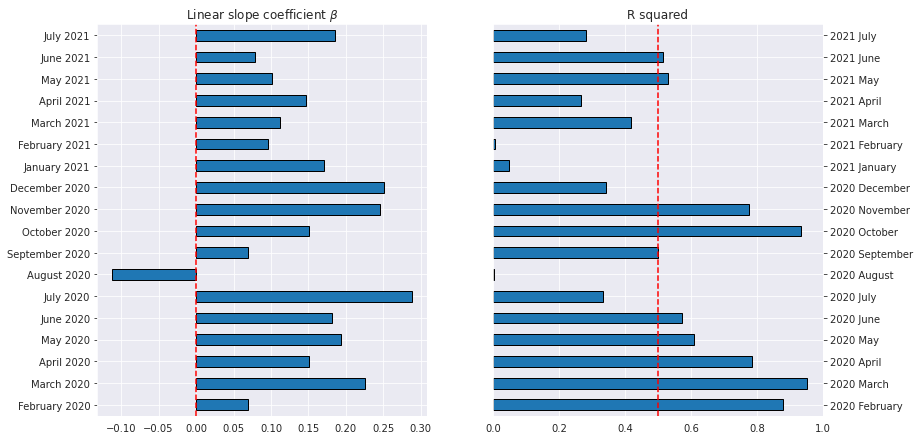

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(13, month_params.index.size/2.5))
month_params.beta.plot(kind='barh', ax=ax[0], title=r'Linear slope coefficient $\beta$', ec='k')
ax[0].axvline(.0, color='r', ls='--')
ax[0].yaxis.tick_left()
month_params.set_index('month_inv').R2.plot(
    kind='barh', ax=ax[1], xlim=(0, 1), title='R squared', ec='k'
)
ax[1].yaxis.tick_right()
ax[1].axvline(.5, color='r', ls='--')
ax[1].set(
    ylabel=None,
)
plt.show()

In [34]:
_ = """
lines = {
    'mese': [], 'terapia intensiva': [], 'nuovi deceduti': [], 'R2': []
}
x = np.linspace(0, df.terapia_intensiva.max(), 2)
for i, mese in enumerate(params):
    lines['mese'].append(mese)
    lines['mese'].append(mese)
    lines['terapia intensiva'].append(x[0])
    lines['terapia intensiva'].append(x[1])
    _y = params[mese]['alpha'] + params[mese]['beta'] * x
    lines['nuovi deceduti'].append(_y[0])
    lines['nuovi deceduti'].append(_y[1])
    lines['R2'].append(params[mese]['R2'])
    lines['R2'].append(params[mese]['R2'])

g = sns.relplot(
    kind='line',
    data=pd.DataFrame(lines).iloc[::-1],
    x='terapia intensiva', y='nuovi deceduti',
    hue='mese', size='mese', sizes=(1, 5), style='mese',
    alpha=.75,
    aspect=2
)
g.axes.flat[0].set_title('Correlazioni stimate terapia intensiva e nuovi deceduti per mese', fontsize=15)
ylim = g.axes.flat[0].get_ylim()
g.axes.flat[0].set(
    ylim=(-100, ylim[1])
)
g.axes.flat[0].axhline(0, color='k', alpha=.25)
plt.show()
"""